In [2]:
import requests
import zipfile

urt = 'http://www.nustm.cn/member/rxia/ml/data/Exam.zip' 
filename = 'Exam.zip'

def download_dataset(url, filename):
    data = requests.get(url)
    with open(filename, 'wb') as code:
        code.write(data.content)
    print(f"Downloading the datasets {filename} complete.")
    data_file = zipfile.ZipFile(filename, 'r')
    data_list = data_file.namelist()

    for file in data_list:
        data_file.extract(file, 'd:/Desktop/AI-ML-methods/homework/assignment2/')
    data_file.close()
    print(f"Unzipping the datasets {filename} complete.")

# download_dataset(urt, filename)

C:\Users\13476\AppData\Local\Temp\ipykernel_12984\2321577915.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_aug[:, 0], X_aug[:, 1], c=y, cmap=plt.cm.get_cmap('flag', 2))


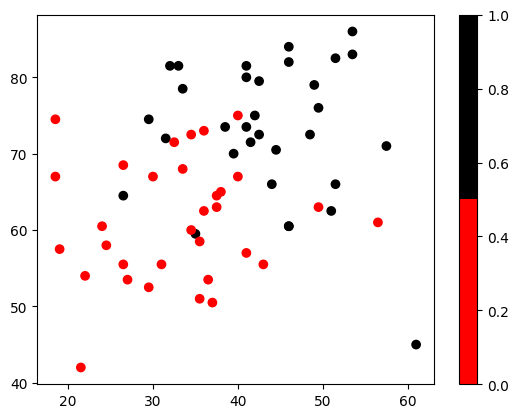

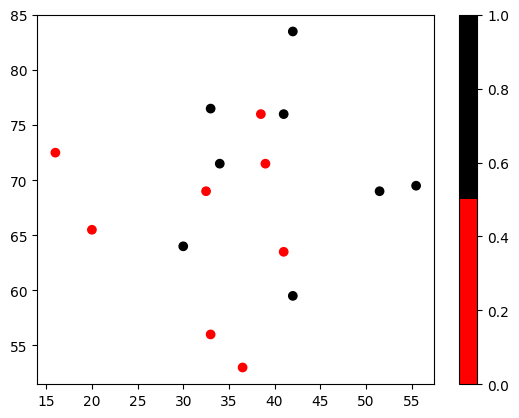

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X_train_path = '../Exam/train/x.txt'
y_train_path = '../Exam/train/y.txt'
X_test_path = '../Exam/test/x.txt'
y_test_path = '../Exam/test/y.txt'

def make_dataset(X_path, y_path):
    x_ori = np.loadtxt(X_path)
    # x_ori_std = np.std(x_ori, axis=0)
    # x_ori_mean = np.mean(x_ori, axis=0)
    # x_tmp = (x_ori - x_ori_mean) / x_ori_std

    X_aug = np.concatenate([x_ori, np.ones((x_ori.shape[0], 1))], axis=1)
    y = np.loadtxt(y_path)
    y = y.reshape(-1, 1)

    # Data visualization
    plt.figure()
    plt.scatter(X_aug[:, 0], X_aug[:, 1], c=y, cmap=plt.cm.get_cmap('flag', 2))
    plt.colorbar()

    return X_aug, y

X_train, y_train = make_dataset(X_train_path, y_train_path)
X_test, y_test = make_dataset(X_test_path, y_test_path)

In [119]:
# sigmoid function
def _sigmoid(z):
    return 1 / (1 + np.exp(-z))

# loss function
def _logistic_loss(y, y_pred):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

# Gradient Descent algorithm
def GD(X, y, learning_rate=0.01, decay=1.0, num_iters=100, verbose = False):
    assert X.shape[0] == len(y) 
    # X.shape: (N, D), y.shape: (N, 1), theta.shape: (D, C)
    theta = np.random.randn(X.shape[1], 1) * 0.001
    loss_history = []
    theta_history = []
    theta_history.append(theta)

    for it in range(num_iters):
        y_pred = _sigmoid(np.dot(X, theta)).reshape(-1, 1)
        loss = _logistic_loss(y, y_pred)
        loss_history.append(loss)

        grad = np.dot(X.T, (y_pred - y)) / len(y)
        # print(X.shape, y.shape, y_pred.shape)
        # print(theta.shape, grad.shape)
        theta -= learning_rate * decay * grad
        theta_history.append(theta)
        if verbose:
            if it % 20 == 0:
                print(f"Iternations: {it} / {num_iters}, loss:{loss}")
    
    return theta, loss_history, theta_history

# Stochastic Gradient Descent algorithm
def SGD(X, y, learning_rate=0.01, decay=1.0, \
        num_iters=100, batch_size=30, verbose=False):
    assert X.shape[0] == len(y)
    if batch_size == -1: # call GD algorithm
        theta, loss_history, theta_history = GD(X, y, learning_rate=learning_rate, decay=decay,\
                                 num_iters=num_iters, verbose=verbose)
    elif batch_size > 0 and batch_size <= len(y):
        theta = np.random.randn(X.shape[1], 1) * 0.001
        loss_history = []
        theta_history = []
        theta_history.append(theta)
        X_batch = None
        y_batch = None

        for it in range(num_iters):
            indices = np.random.choice(X.shape[0], batch_size)
            X_batch = X[indices]
            y_batch = y[indices]

            y_preds = _sigmoid(np.dot(X_batch, theta))
            loss = _logistic_loss(y_batch, y_preds)
            loss_history.append(loss)

            if verbose:
                if it % 20 == 0:
                    print(f"Iternations: {it} / {num_iters}, loss:{loss}")
            
            grad = np.dot(X_batch.T, (y_preds - y_batch) / batch_size)
            theta -= learning_rate * decay * grad
            theta_history.append(theta)

    else: 
        raise(f"batch_size = {batch_size} is not correct")
    
    return theta, loss_history, theta_history

# Newton's Iternation Method
def Newton_method(X, y, num_iters=10, verbose=False):
    assert X.shape[0] == len(y)
    theta = np.random.randn(X.shape[1], 1) * 0.05
    loss_history = []
    theta_history = []
    theta_history.append(theta)

    for it in range(num_iters):
        y_pred = _sigmoid(np.dot(X, theta)).reshape(-1, 1)
        loss = _logistic_loss(y, y_pred)
        loss_history.append(loss)

        grad = np.dot(X.T, (y_pred - y)) / len(y) # grad: (3, 1)
        _diag = np.diagflat(y_pred * (np.ones_like(y) - y_pred))
        # print(_diag.shape)
        hessian = X.T.dot(_diag).dot(X)
        theta -= np.linalg.solve(hessian, grad)
        theta_history.append(theta)

        if verbose:
            print(f"Iternations: {it} / {num_iters}, loss:{loss}")
        
    
    return theta, loss_history, theta_history



In [125]:
from matplotlib.animation import FuncAnimation

def logistic_regression(X, y, method='GD', learning_rate=0.01, decay=1.0,\
                         num_iters=100, batch_size=30, verbose=False, save_gif: str=None):
    if method == 'GD':
        theta, losses, thetas = GD(X, y, learning_rate=learning_rate, decay=decay,
                            num_iters=num_iters, verbose=verbose)
    elif method == 'SGD':
        theta, losses, thetas = SGD(X, y, learning_rate=learning_rate, decay=decay,
                            batch_size=batch_size, num_iters=num_iters, verbose=verbose)
    elif method == 'Newton':
        theta, losses, thetas = Newton_method(X, y, num_iters=num_iters, verbose=verbose)
    

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].cla()
    axs[0].plot(range(len(losses)), losses, color='blue')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    def update_plot(epoch):
        axs[1].cla()
        axs[1].scatter(X[:, 0], X[:, 1], c=y, marker='x', cmap=plt.cm.get_cmap('flag', 2))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        X_grid = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1), 
                                 np.ones((len(xx.ravel()), 1))], axis=1)
        Z = _sigmoid(np.dot(X_grid, thetas[epoch]))
        Z = Z.reshape(xx.shape)
        axs[1].contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.get_cmap('prism', 2))
        axs[1].set_title(f'Epoch: {epoch}')

    ani = FuncAnimation(fig, update_plot, frames=len(losses), interval=1)
    fig.show()
    if save_gif:
        ani.save(f"{save_gif}.gif", fps=20, writer="imagemagick")   
    return theta, losses, thetas

def logistic_predict(theta, X_test, y_test):
    assert X_test.shape[0] == y_test.shape[0]
    assert theta.shape[0] == X_test.shape[1]
    y_pred = _sigmoid(np.dot(X_test, theta)).reshape(-1, 1)
    acc_test = np.mean(y_pred == y_test)
    return y_pred, acc_test


C:\Users\13476\AppData\Local\Temp\ipykernel_15684\843196811.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
MovieWriter imagemagick unavailable; using Pillow instead.


Iternations: 0 / 100, loss:0.9884798607868098
Iternations: 20 / 100, loss:0.6804116371827817
Iternations: 40 / 100, loss:0.6748097885177933
Iternations: 60 / 100, loss:0.6719517827647248
Iternations: 80 / 100, loss:0.6704556047291332


C:\Users\13476\AppData\Local\Temp\ipykernel_15684\843196811.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[1].scatter(X[:, 0], X[:, 1], c=y, marker='x', cmap=plt.cm.get_cmap('flag', 2))
C:\Users\13476\AppData\Local\Temp\ipykernel_15684\843196811.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[1].contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.get_cmap('prism', 2))


Accuracy on testing data: 0.0


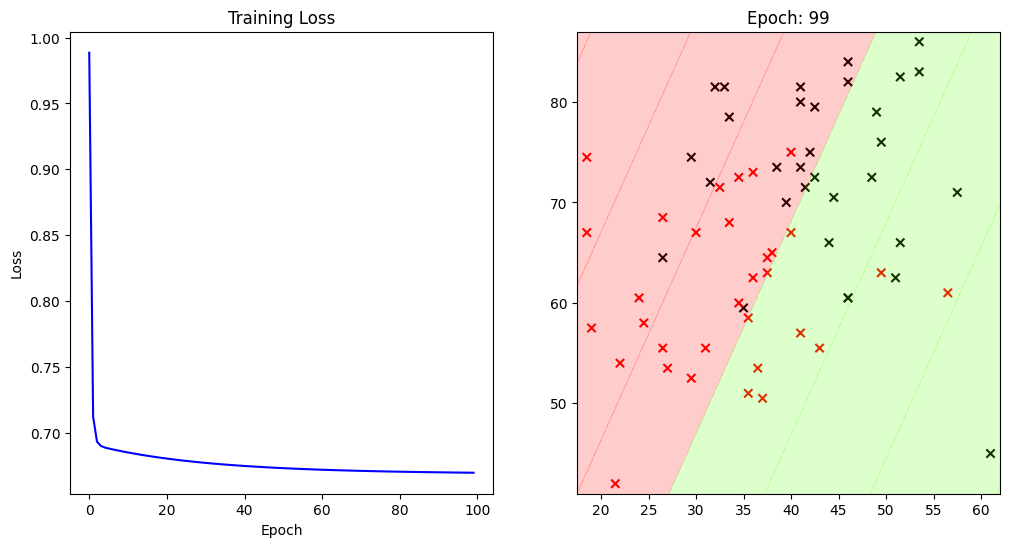

In [126]:
theta, _, _ = logistic_regression(X_train, y_train, method='GD', learning_rate=0.001, decay=0.95, 
                               num_iters=100, batch_size=30, verbose=True, save_gif='gd')

_, acc_test = logistic_predict(theta, X_test, y_test)
print(f"Accuracy on testing data: {acc_test}")